## 캐글 경진대회 베이스라인 모델

### 라이브러리 임포트

In [534]:
# 필요한 모듈 임포트
import os
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from plt_rcs import *
import hds
import numpy as np

### 데이터셋 준비

In [535]:
# 캐글 작업 경로
# kaggle_path = r'C:\Users\fins\Downloads\binary-classification-for-dobong-campus'

# 작업 경로 변경
os.chdir('../data')

In [536]:
# 현재 작업 경로에 있는 폴더명과 파일명 목록 확인
sorted(os.listdir())

['drop_null_model.csv', 'sample_submission.csv', 'test.csv', 'train.csv']

In [537]:
# 데이터셋 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

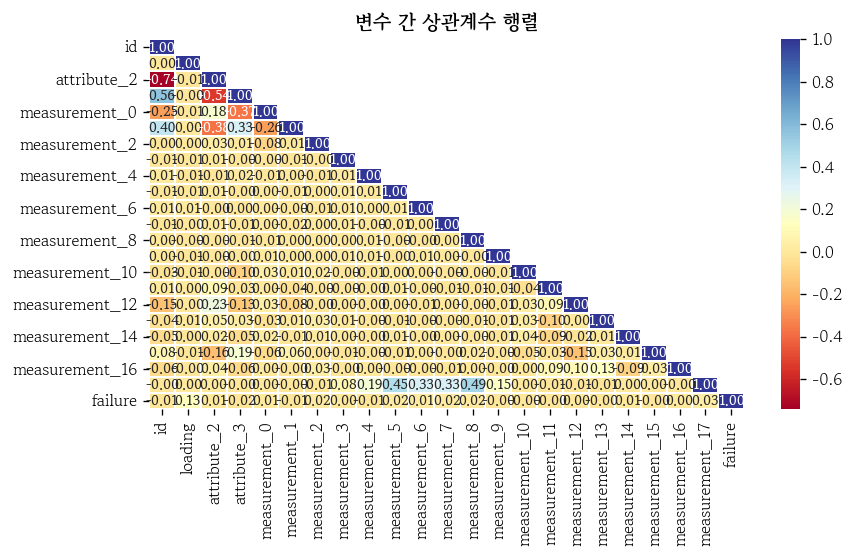

In [538]:
hds.plot.corr_heatmap(train, fontsize=8)

In [539]:
# 데이터셋 행 개수와 열 개수 확인
print(train.shape)
print(test.shape)

(26570, 26)
(20775, 25)


In [540]:
# 훈련셋 처음 5행 확인
train.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [541]:
# 훈련셋 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26570 entries, 0 to 26569
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              26570 non-null  int64  
 1   product_code    26570 non-null  object 
 2   loading         26320 non-null  float64
 3   attribute_0     26570 non-null  object 
 4   attribute_1     26570 non-null  object 
 5   attribute_2     26570 non-null  int64  
 6   attribute_3     26570 non-null  int64  
 7   measurement_0   26570 non-null  int64  
 8   measurement_1   26570 non-null  int64  
 9   measurement_2   26570 non-null  int64  
 10  measurement_3   26189 non-null  float64
 11  measurement_4   26032 non-null  float64
 12  measurement_5   25894 non-null  float64
 13  measurement_6   25774 non-null  float64
 14  measurement_7   25633 non-null  float64
 15  measurement_8   25522 non-null  float64
 16  measurement_9   25343 non-null  float64
 17  measurement_10  25270 non-null 

In [542]:
# 훈련셋 열별 결측값 개수 확인
train.isna().sum()

id                   0
product_code         0
loading            250
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
failure              0
dtype: int64

In [543]:
# 시험셋 처음 5행 확인
test.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044


In [544]:
# 시험셋 정보 확인
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20775 entries, 0 to 20774
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20775 non-null  int64  
 1   product_code    20775 non-null  object 
 2   loading         20552 non-null  float64
 3   attribute_0     20775 non-null  object 
 4   attribute_1     20775 non-null  object 
 5   attribute_2     20775 non-null  int64  
 6   attribute_3     20775 non-null  int64  
 7   measurement_0   20775 non-null  int64  
 8   measurement_1   20775 non-null  int64  
 9   measurement_2   20775 non-null  int64  
 10  measurement_3   20446 non-null  float64
 11  measurement_4   20366 non-null  float64
 12  measurement_5   20267 non-null  float64
 13  measurement_6   20151 non-null  float64
 14  measurement_7   20055 non-null  float64
 15  measurement_8   19929 non-null  float64
 16  measurement_9   19871 non-null  float64
 17  measurement_10  19708 non-null 

In [545]:
# 시험셋 열별 결측값 개수 확인
test.isna().sum()

id                   0
product_code         0
loading            223
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      329
measurement_4      409
measurement_5      508
measurement_6      624
measurement_7      720
measurement_8      846
measurement_9      904
measurement_10    1067
measurement_11    1136
measurement_12    1240
measurement_13    1303
measurement_14    1440
measurement_15    1542
measurement_16    1678
measurement_17    1740
dtype: int64

In [546]:
train.columns

Index(['id', 'product_code', 'loading', 'attribute_0', 'attribute_1',
       'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17',
       'failure'],
      dtype='object')

In [547]:
train['attribute_1'].value_counts()

attribute_1
material_8    10865
material_5    10362
material_6     5343
Name: count, dtype: int64

### 특성 행렬과 타겟 벡터로 분리

In [548]:
# 타겟 벡터명 설정
yvar = 'failure'

# 훈련셋 특성 행렬 생성
X = train.drop(columns = yvar)

# 훈련셋 타겟 벡터 생성
y = train[yvar].copy()

In [549]:
# 시험셋 특성 행렬 생성
X_test = test.copy()

### 이상치 확인

In [550]:
train.iloc[:,:23].describe().round(3)

,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15
count,26570.000,26320.000,26570.000,26570.000,26570.000,26570.000,26570.000,26189.000,26032.000,25894.000,25774.000,25633.000,25522.000,25343.000,25270.000,25102.000,24969.000,24796.000,24696.000,24561.000
mean,13284.500,127.826,6.754,7.240,7.416,8.233,6.257,17.792,11.732,17.128,17.511,11.717,19.025,11.431,16.118,19.172,11.702,15.653,16.048,14.996
std,7670.243,39.030,1.472,1.456,4.117,4.199,3.309,1.001,0.996,0.996,0.996,1.001,1.009,0.999,1.406,1.521,1.489,1.155,1.492,1.549
min,0.000,33.160,5.000,5.000,0.000,0.000,0.000,13.968,8.008,12.073,12.715,7.968,15.217,7.537,9.323,12.461,5.167,10.890,9.140,9.104
25%,6642.250,99.988,6.000,6.000,4.000,5.000,4.000,17.117,11.051,16.443,16.839,11.045,18.340,10.757,15.209,18.170,10.703,14.890,15.057,13.957
50%,13284.500,122.390,6.000,8.000,7.000,8.000,6.000,17.787,11.733,17.132,17.516,11.712,19.021,11.430,16.127,19.212,11.717,15.628,16.040,14.969
75%,19926.750,149.152,8.000,8.000,10.000,11.000,8.000,18.469,12.410,17.805,18.178,12.391,19.708,12.102,17.025,20.207,12.709,16.374,17.082,16.018
max,26569.000,385.860,9.000,9.000,29.000,29.000,24.000,21.499,16.484,21.425,21.543,15.419,23.807,15.412,22.479,25.640,17.663,22.713,22.303,21.626


In [551]:
# loading 이상치 확인
Q1 = train['loading'].quantile(0.25)
Q3 = train['loading'].quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR

outliers = train[train['loading'] > upper]
print(f"loading 이상치 : {len(outliers)} 개 ({len(outliers)/len(train)*100:.1f} %)")

loading 이상치 : 589 개 (2.2 %)


In [552]:
# loading 이상치 처리
X['loading'] = X['loading'].clip(upper=upper)
X_test['loading'] = X_test['loading'].clip(upper=upper)

### 데이터 전처리

In [553]:
# 단순 식별자인 'id' 제거
X = X.drop(columns = 'id')
X_test = X_test.drop(columns = 'id')

In [554]:
# 결측치 개수 피처 생성
X['null_count'] = X.isnull().sum(axis=1)
X_test['null_count'] = X_test.isnull().sum(axis=1)

In [555]:
X['null_count'].value_counts()

null_count
0    12183
1     9680
2     3675
3      901
4      117
5       12
6        2
Name: count, dtype: int64

In [556]:
X['null_count'] = X['null_count'].clip(upper=3)
X_test['null_count'] = X_test['null_count'].clip(upper=3)

In [557]:
# 로그 변환
X['loading'] = np.log1p(X['loading'])
X_test['loading'] = np.log1p(X_test['loading'])

In [558]:
# 수치형 특성만 선택
numeric_features = X.select_dtypes(include = ['int64', 'float64']).columns.tolist()

# 수치형 특성 목록 확인
print(numeric_features)

['loading', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17', 'null_count']


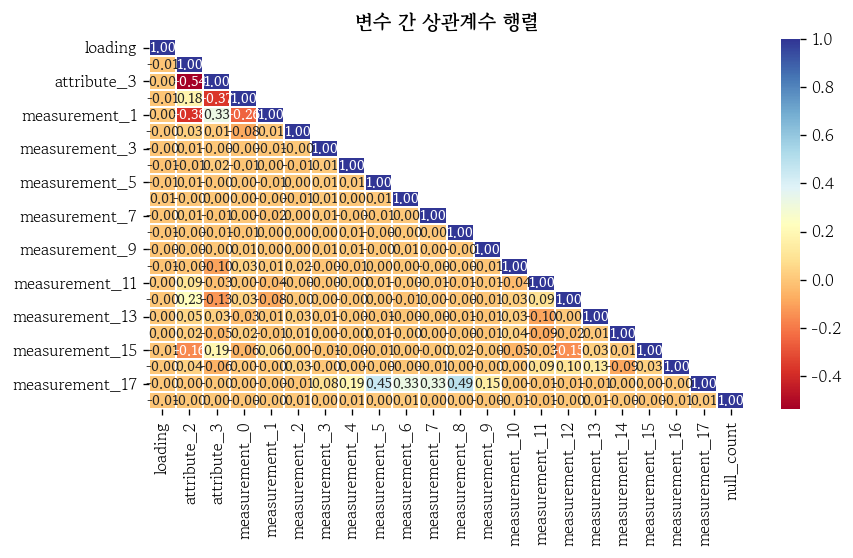

In [559]:
hds.plot.corr_heatmap(X, fontsize=8)

In [560]:
# 범주형 특성만 선택
categorical_features = X.select_dtypes(include = ['object']).columns.tolist()

# 범주형 특성 목록 확인
print(categorical_features)

['product_code', 'attribute_0', 'attribute_1']


### 결측값 전처리 파이프라인 정의

- 수치형: 결측을 중앙값으로 채우고 표준화
- 범주형: 결측을 최빈값으로 채우고 원-핫 인코딩

In [561]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 1. measurement_4~17 제외한 결측값 채우기
meas_impute_cols = [f'measurement_{i}' for i in range(9, 18)]
numeric_features_except_meas = [col for col in numeric_features if col not in meas_impute_cols]

for col in numeric_features_except_meas:
    product_means = X.groupby('product_code')[col].mean()
    X[col] = X[col].fillna(X.groupby('product_code')[col].transform('mean'))
    X_test[col] = X_test[col].fillna(X_test['product_code'].map(product_means))

train_median = X[numeric_features_except_meas].median()
X[numeric_features_except_meas] = X[numeric_features_except_meas].fillna(train_median)
X_test[numeric_features_except_meas] = X_test[numeric_features_except_meas].fillna(train_median)

# 2. measurement_4~17 IterativeImputer
imputer = IterativeImputer(random_state=0, max_iter=10)
X[meas_impute_cols] = imputer.fit_transform(X[meas_impute_cols])
X_test[meas_impute_cols] = imputer.transform(X_test[meas_impute_cols])

In [562]:
X['loading_null'] = X['loading'] * X['null_count']
X_test['loading_null'] = X_test['loading'] * X_test['null_count']

In [563]:
X['is_missing'] = (X['null_count'] > 0).astype(int)
X_test['is_missing'] = (X_test['null_count'] > 0).astype(int)

In [564]:
X = X.drop(columns=['null_count'])
X_test = X_test.drop(columns=['null_count'])

In [565]:
# # product_code별 그룹 평균으로 결측값 채우기
# for col in numeric_features:
#     # Train의 product_code별 평균 계산
#     product_means = X.groupby('product_code')[col].mean()

#     # Train 채우기 (자기 자신의 평균)
#     X[col] = X[col].fillna(X.groupby('product_code')[col].transform('mean'))

#     # Test는 Train 평균으로 매핑 (A~E는 매핑, F~I는 NaN 유지)
#     X_test[col] = X_test[col].fillna(X_test['product_code'].map(product_means))

# # 잔여 결측값 Train 중위수로 채우기
# train_median = X[numeric_features].median()
# X[numeric_features] = X[numeric_features].fillna(train_median)
# X_test[numeric_features] = X_test[numeric_features].fillna(train_median)

In [566]:
# 파이프라인
numeric_transformer = Pipeline(
    steps = [
        ('scaler', RobustScaler())
    ]
)

categorical_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

### 훈련셋과 검증셋으로 분할

In [567]:
# 훈련셋과 검증셋으로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 0,
    stratify = y
)

In [568]:
# 훈련셋과 검증셋의 행 개수와 열 개수 확인
print(X_train.shape)
print(X_valid.shape)

(21256, 26)
(5314, 26)


In [569]:
# 로지스틱 회귀 모델 생성
model = LogisticRegression(
    max_iter = 1000,
    n_jobs = -1,
    C=0.1
)

# 이진 분류 모델 파이프라인 정의
clf = Pipeline(
    steps = [
        ('preprocess', preprocessor),
        ('model', model),
    ]
)

### 베이스라인 모델 파이프라인 정의

In [570]:
# 베이스라인 모델 학습
clf.fit(X = X_train, y = y_train)

ValueError: A given column is not a column of the dataframe

### 검증셋 ROC-AUC 확인

In [ ]:
# 검증셋 예측확률 생성: 2차원 배열이므로 두 번째 열만 선택
y_valid_prob = clf.predict_proba(X = X_valid)[:, 1]

# 검증셋 예측확률로 ROC-AUC 점수 확인
y_valid_auc = roc_auc_score(y_true = y_valid, y_score = y_valid_prob)
print(f'{y_valid_auc:.5f}')

0.60062


### 검증셋 일반화 테스트

In [ ]:
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')

In [ ]:
print(cv_scores.mean().round(5))

0.5927


### 전체 훈련셋으로 재학습
- 시험셋 예측값을 생성하기 전, 전체 훈련셋(X, y)로 재학습을 해야 모델의 성능이 향상됨

In [ ]:
# 전체 훈련셋으로 재학습
clf.fit(X = X, y = y)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 시험셋 예측값 생성

In [ ]:
# 시험셋 예측확률 생성: 2차원 배열이므로 두 번째 열만 선택
y_test_prob = clf.predict_proba(X = X_test)[:, 1]

### 제출 파일 생성
- sample_submission.csv 형식 그대로 사용

In [ ]:
# 제출 파일용 데이터 불러오기
submit = pd.read_csv('sample_submission.csv')

In [ ]:
# submit의 처음 5행 확인
submit.head()

,id,failure
0,26570,0.0
1,26571,0.0
2,26572,0.0
3,26573,0.0
4,26574,0.0


In [ ]:
# test와 submit의 행 개수와 열 개수 확인
print(test.shape)
print(submit.shape)

(20775, 25)
(20775, 2)


In [ ]:
# submit의 failure에 시험셋 에측확률 할당
submit[yvar] = y_test_prob

In [ ]:
# submit의 처음 5행 확인
submit.head()

,id,failure
0,26570,0.215788
1,26571,0.165526
2,26572,0.188370
3,26573,0.192493
4,26574,0.333924


In [ ]:
# 제출 파일 생성
submit_filename = 'drop_null_model.csv'
submit.to_csv(path_or_buf = submit_filename, index = False)

## End of Document